https://github.com/AminHP/gym-anytrading

In [35]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines3.dqn import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

import matplotlib.pyplot as plt

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
import torch as th

In [74]:
# BTC_df = pd.read_csv("out_BTCUSDT_220705.csv")
BTC_df = pd.read_csv("out_data.csv")
# BTC_df = pd.read_csv("BTC_USDT.csv")

In [93]:
BTC_df=BTC_df.iloc[:50000,:]

In [94]:
BTC_df

,Price,z0,z1,z2
0,6990.95,-0.811159,0.567795,-0.355002
1,6989.08,-0.557435,0.379988,-0.371280
2,6986.99,-0.466278,0.326650,-0.369995
3,6976.85,-0.639778,0.507369,-0.384283
4,6964.86,-0.831750,0.671901,-0.390888
...,...,...,...,...
49995,9900.12,0.591458,-0.120794,1.905484
49996,9900.13,0.246538,-0.026205,1.898483
49997,9900.11,0.088514,0.084568,1.902327
49998,9900.01,-0.387325,0.244207,1.924122


In [95]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Price'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['z0', 'z1', 'z2']].to_numpy()[start:end]
    return prices, signal_features



# def my_process_data(env):
#     prices = env.df.loc[:, 'close'].to_numpy()

#     prices[env.frame_bound[0] - env.window_size]  # validate index (TODO: Improve validation)
#     prices = prices[env.frame_bound[0]-env.window_size:env.frame_bound[1]]

#     diff = np.insert(np.diff(prices), 0, 0)
#     signal_features = np.column_stack((prices, diff))

#     return prices, signal_features

class MyCoinEnv(StocksEnv):
    _process_data = my_process_data


env_maker = lambda: MyCoinEnv(df=BTC_df, window_size=1, frame_bound=(2, len(BTC_df)))

env = DummyVecEnv([env_maker])

window_size = 1
start_index = window_size
end_index = len(BTC_df)

env.trade_fee_bid_percent=0.0002
env.trade_fee_ask_percent=0.0002


In [96]:
model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=200000, progress_bar=True)
     

Output()

Using cpu device


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1472     |
|    time_elapsed     | 135      |
|    total_timesteps  | 199988   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00653  |
|    n_updates        | 37496    |
----------------------------------


In [103]:
env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    # with th.no_grad():
    #     obs_tensor, _ = model.q_net.obs_to_tensor(observation)
    #     q_values = model.q_net(obs_tensor)
        #print(q_values)
    #print(_states)
    
    observation, reward, done, info = env.step(action)
    #print(observation)
    # print(reward)
    # env.render()
    if done:
        print("info:", info)
        break
     

info: {'total_reward': -26194.670000000064, 'total_profit': 4.72135986189268e-25, 'position': 1}


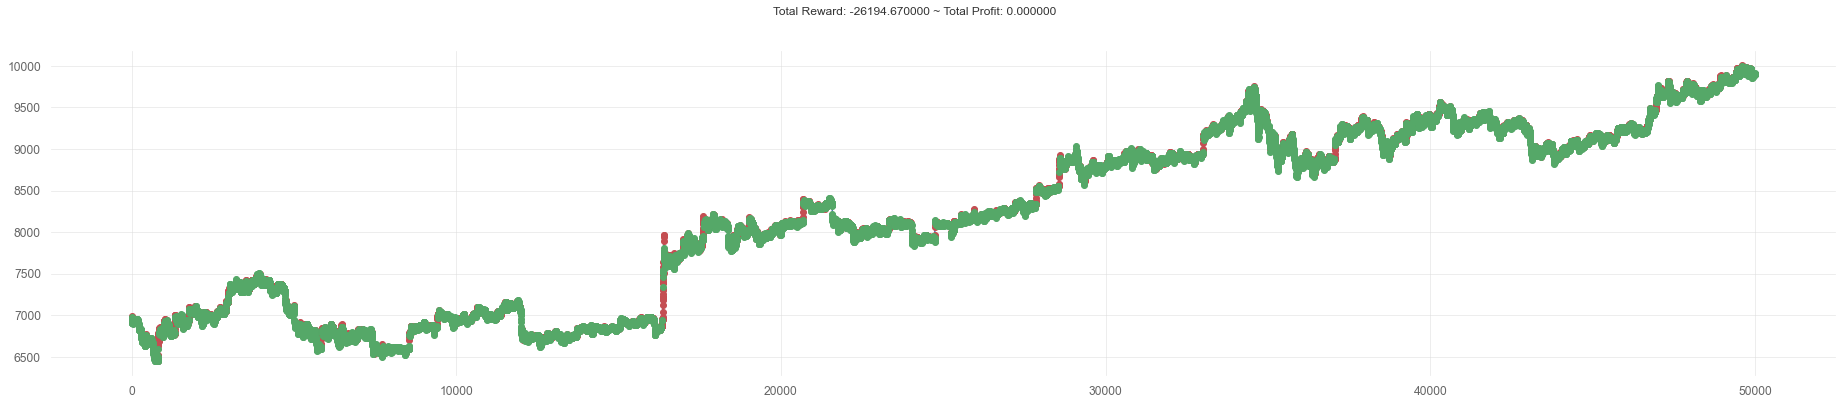

In [104]:
plt.figure(figsize=(32, 6))
env.render_all()
plt.show()

In [105]:
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())


env information:
> shape: (1, 3)
> df.shape: (50000, 4)
> prices.shape: (49999,)
> signal_features.shape: (49999, 3)
> max_possible_profit: 77171133.98129664


In [29]:

qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=BTC_df.index[start_index+2:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='dqn_quantstats.html')

AttributeError: 'int' object has no attribute 'days'